In [3]:
#mounting and creating temprorary connection to where the dataset in the drive is
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_path = '/content/drive/MyDrive/traffic_project/'

In [ ]:
!pip install osmnx
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os




In [ ]:
#loding the us accident data file and printing data before cleaning it and after its cleaned and visualising it
us_file = project_path + 'US_Accidents_March23.csv.zip'
cols = [
    'ID','Severity','Start_Time','End_Time','Start_Lat','Start_Lng','City','State',
    'Temperature(F)','Humidity(%)','Visibility(mi)','Weather_Condition',
    'Wind_Speed(mph)','Precipitation(in)','Sunrise_Sunset'
]
chunksize = 400000
total_rows = 0
null_summary = pd.DataFrame()
preview = pd.read_csv(us_file, usecols=cols, nrows=5000)
print("Initial Preview of US Dataset:\n")
print(preview.info())
print(preview.head())

Initial Preview of US Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5000 non-null   object 
 1   Severity           5000 non-null   int64  
 2   Start_Time         5000 non-null   object 
 3   End_Time           5000 non-null   object 
 4   Start_Lat          5000 non-null   float64
 5   Start_Lng          5000 non-null   float64
 6   City               5000 non-null   object 
 7   State              5000 non-null   object 
 8   Temperature(F)     4978 non-null   float64
 9   Humidity(%)        4978 non-null   float64
 10  Visibility(mi)     4958 non-null   float64
 11  Wind_Speed(mph)    4541 non-null   float64
 12  Precipitation(in)  192 non-null    float64
 13  Weather_Condition  4964 non-null   object 
 14  Sunrise_Sunset     5000 non-null   object 
dtypes: float64(7), int64(1), object(7)
memor

🔹 Raw Chunk Shape: (400000, 15)

--- RAW CHUNK INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 400000 non-null  object 
 1   Severity           400000 non-null  int64  
 2   Start_Time         400000 non-null  object 
 3   End_Time           400000 non-null  object 
 4   Start_Lat          400000 non-null  float64
 5   Start_Lng          400000 non-null  float64
 6   City               399981 non-null  object 
 7   State              400000 non-null  object 
 8   Temperature(F)     394085 non-null  float64
 9   Humidity(%)        393491 non-null  float64
 10  Visibility(mi)     391221 non-null  float64
 11  Wind_Speed(mph)    325829 non-null  float64
 12  Precipitation(in)  42045 non-null   float64
 13  Weather_Condition  391792 non-null  object 
 14  Sunrise_Sunset     399981 non-null  object 


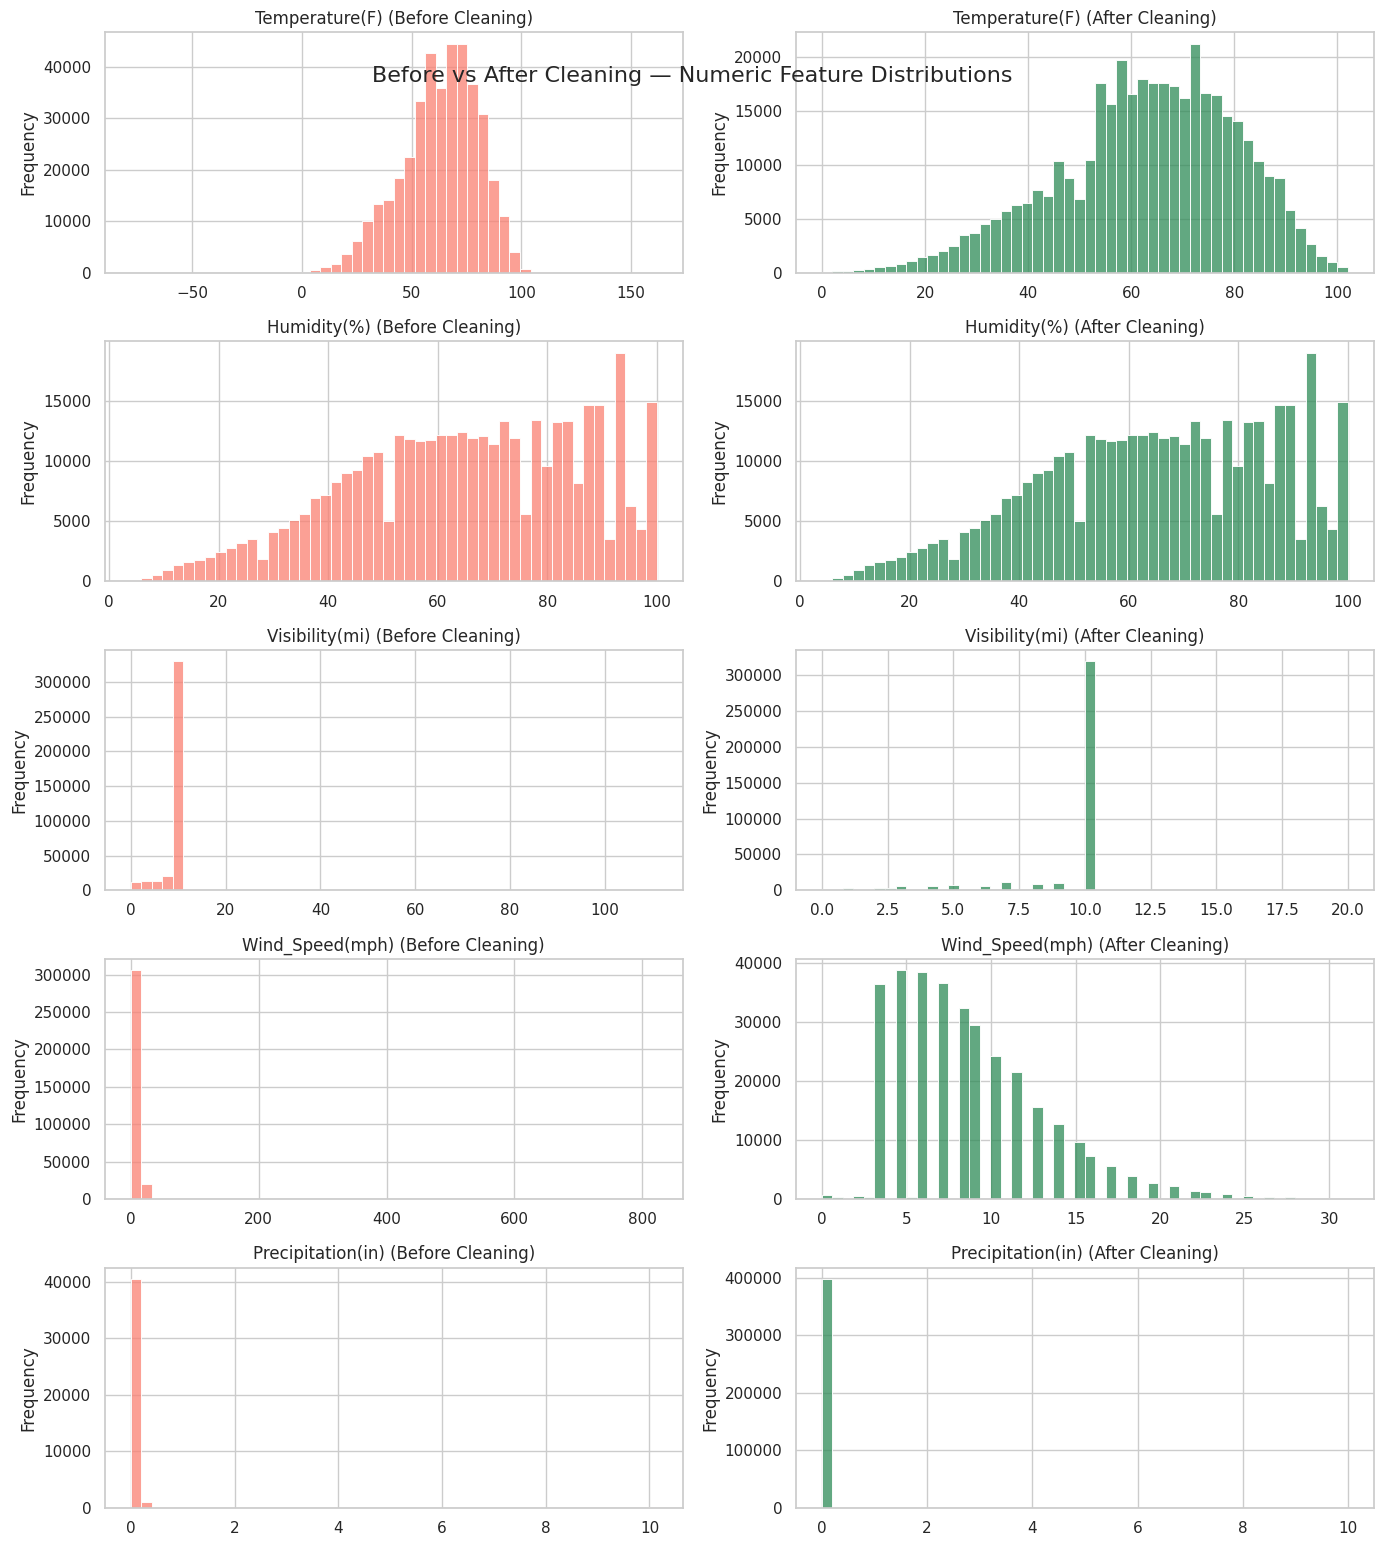

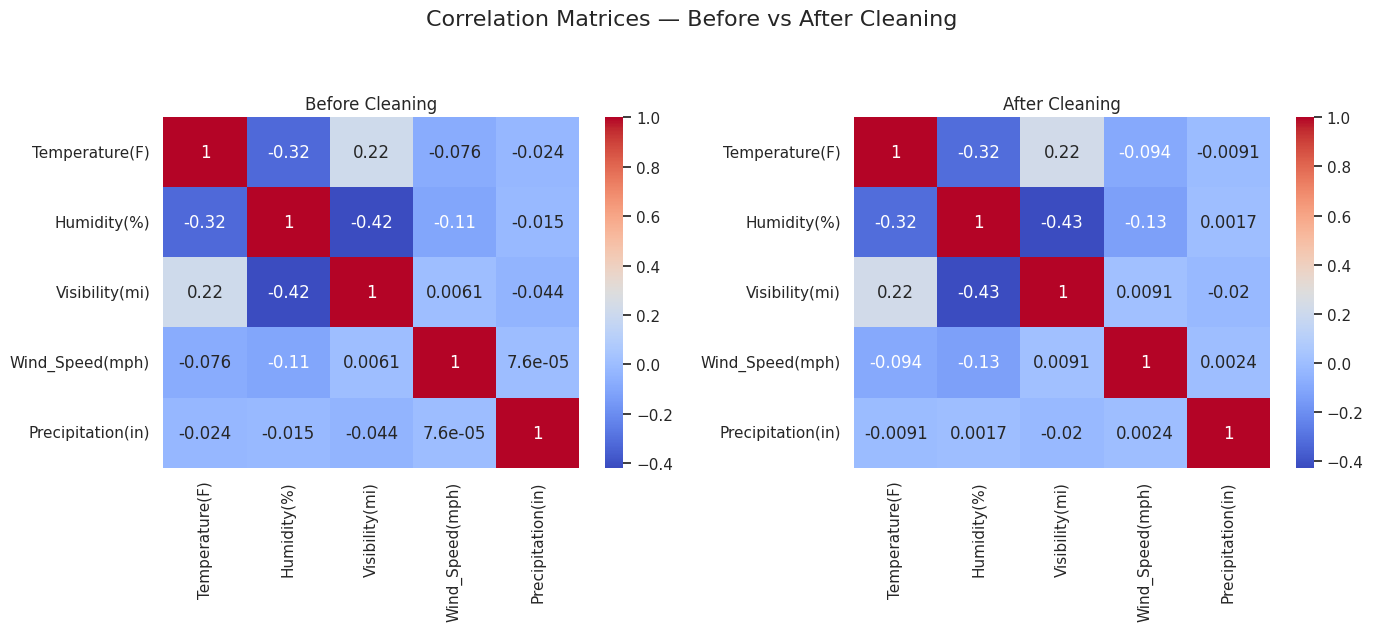

In [ ]:
num_cols = ['Temperature(F)','Humidity(%)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']
chunk_iter = pd.read_csv(us_file, usecols=cols, chunksize=chunksize, low_memory=False)
raw_chunk = next(chunk_iter)
print("🔹 Raw Chunk Shape:", raw_chunk.shape)
print("\n--- RAW CHUNK INFO ---")
print(raw_chunk.info())
print("\n--- Missing Values (Raw) ---")
print(raw_chunk.isna().sum())
print("\n--- Raw Descriptive Stats ---")
print(raw_chunk[num_cols].describe())
def clean_chunk(df):
    df = df.copy()
    df.dropna(subset=['Start_Lat','Start_Lng'], inplace=True)
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time']   = pd.to_datetime(df['End_Time'], errors='coerce')

    # numeric cleaning with realistic filling
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df.loc[df[col] < 0, col] = np.nan
            upper = df[col].quantile(0.999)
            df.loc[df[col] > upper, col] = np.nan

    if col == 'Precipitation(in)':
                # generate random values only for NaNs
                rand_vals = np.random.uniform(0, 0.1, size=df[col].isna().sum())
                df.loc[df[col].isna(), col] = rand_vals
    elif col == 'Visibility(mi)':
                df[col] = df[col].fillna(df[col].mean())
    else:
                df[col] = df[col].fillna(df[col].median())


    for col in ['Weather_Condition','Sunrise_Sunset','City','State']:
        mode_val = df[col].mode()[0] if df[col].notna().any() else 'Unknown'
        df[col] = df[col].fillna(mode_val)
    return df
clean_chunk_sample = clean_chunk(raw_chunk)
print("\n✅ CLEANING COMPLETE (Sample)")
print("Cleaned Chunk Shape:", clean_chunk_sample.shape)
print("\n==============================")
print("📊 QUANTITATIVE COMPARISON")
print("==============================")
print("\n--- BEFORE CLEANING ---")
print(raw_chunk[num_cols].describe())
print("\n--- AFTER CLEANING ---")
print(clean_chunk_sample[num_cols].describe())

print("\n--- Missing Values After Cleaning ---")
print(clean_chunk_sample.isna().sum())
sns.set(style="whitegrid")
fig, axes = plt.subplots(len(num_cols), 2, figsize=(14, 16))
fig.suptitle("Before vs After Cleaning — Numeric Feature Distributions", fontsize=16, y=0.93)

for i, col in enumerate(num_cols):
    # Before
    sns.histplot(raw_chunk[col], bins=50, color="salmon", ax=axes[i,0])
    axes[i,0].set_title(f"{col} (Before Cleaning)")
    axes[i,0].set_xlabel("")
    axes[i,0].set_ylabel("Frequency")

    # After
    sns.histplot(clean_chunk_sample[col], bins=50, color="seagreen", ax=axes[i,1])
    axes[i,1].set_title(f"{col} (After Cleaning)")
    axes[i,1].set_xlabel("")
    axes[i,1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,2, figsize=(14,6))
fig.suptitle("Correlation Matrices — Before vs After Cleaning", fontsize=16, y=1.05)

sns.heatmap(raw_chunk[num_cols].corr(), cmap="coolwarm", annot=True, ax=ax[0])
ax[0].set_title("Before Cleaning")

sns.heatmap(clean_chunk_sample[num_cols].corr(), cmap="coolwarm", annot=True, ax=ax[1])
ax[1].set_title("After Cleaning")

plt.tight_layout()
plt.show()
clean_chunk_sample.to_csv(project_path + 'US_Accidents_Cleaned_Sample.csv', index=False)


In [ ]:
project_path = '/content/drive/MyDrive/traffic_project/'
osm_file = project_path + 'norcal-251013.osm.pbf'

print("📂 Loading OSM (lines layer only)... this may take a few minutes")
roads_raw = gpd.read_file(osm_file, layer='lines')
print(f"✅ Loaded {len(roads_raw)} road records")
print("Columns:", list(roads_raw.columns))

📂 Loading OSM (lines layer only)... this may take a few minutes
✅ Loaded 2908172 road records
Columns: ['osm_id', 'name', 'highway', 'waterway', 'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags', 'geometry']


In [ ]:
n = len(roads_raw)
chunk_size = n // 3

chunks = [
    roads_raw.iloc[i:i+chunk_size].copy()
    for i in range(0, n, chunk_size)
]

print(f"✅ Split into {len(chunks)} chunks of approximately {chunk_size} rows each")

✅ Split into 4 chunks of approximately 969390 rows each


In [ ]:
def extract_tag(tag_string, key):
    """Extracts a key's value from OSM 'other_tags' string."""
    if pd.isna(tag_string):
        return np.nan
    import re
    match = re.search(fr'"{key}"=>"([^"]+)"', tag_string)
    return match.group(1) if match else np.nan


def clean_osm_chunk(chunk, idx):
    """Cleans a single OSM chunk and visualizes it."""
    print(f"\n🧹 Cleaning OSM chunk {idx+1}/3 ...")

    keep_cols = ['osm_id', 'name', 'highway', 'other_tags', 'geometry']
    chunk = chunk[keep_cols].copy()

    # Extract tags
    chunk['lanes'] = chunk['other_tags'].apply(lambda x: extract_tag(x, 'lanes'))
    chunk['maxspeed'] = chunk['other_tags'].apply(lambda x: extract_tag(x, 'maxspeed'))

    # Convert to numeric
    chunk['lanes'] = pd.to_numeric(chunk['lanes'], errors='coerce')
    chunk['maxspeed'] = chunk['maxspeed'].astype(str).str.extract(r'(\d+)').astype(float)

    # Compute length (project to meters)
    chunk = chunk.to_crs(epsg=3857)
    chunk['length'] = chunk.geometry.length
    chunk = chunk.to_crs(epsg=4326)

    # Fill missing values
    chunk['lanes'].fillna(1, inplace=True)
    chunk['maxspeed'].fillna(35, inplace=True)
    chunk['length'].fillna(chunk['length'].median(), inplace=True)
    chunk['highway'].fillna('unknown', inplace=True)
    chunk['name'].fillna('unnamed', inplace=True)

    chunk.drop(columns=['other_tags'], inplace=True)

    print(f"✅ Chunk {idx+1} cleaned successfully: {len(chunk)} rows")

    # ---------- Quantitative Summary ----------
    print("\n📊 Quantitative Summary")
    num_cols = ['lanes', 'maxspeed', 'length']
    print(chunk[num_cols].describe())

    # ---------- Visualization ----------
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Chunk {idx+1} — Road Feature Distributions", fontsize=15, y=1.05)

    for ax, col in zip(axes, num_cols):
        sns.histplot(chunk[col], bins=50, color="seagreen", ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    corr = chunk[num_cols].corr()
    plt.figure(figsize=(5, 4))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Chunk {idx+1} — Correlation Heatmap")
    plt.show()

    # Spatial preview
    sample = chunk.sample(min(2000, len(chunk)))
    sample.plot(figsize=(8, 8), color='lightblue', linewidth=0.5)
    plt.title(f"Chunk {idx+1} — Road Network Sample")
    plt.axis('off')
    plt.show()

    return chunk


🧹 Cleaning OSM chunk 1/3 ...


/tmp/ipython-input-1945707793.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['lanes'].fillna(1, inplace=True)
/tmp/ipython-input-1945707793.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

✅ Chunk 1 cleaned successfully: 969390 rows

📊 Quantitative Summary
               lanes       maxspeed         length
count  969390.000000  969390.000000  969390.000000
mean        1.037633      35.041136     742.186310
std         0.255850       2.811639    2368.394443
min         1.000000       3.000000       0.111307
25%         1.000000      35.000000     142.274934
50%         1.000000      35.000000     325.308116
75%         1.000000      35.000000     718.257543
max         8.000000      79.000000  704799.879400


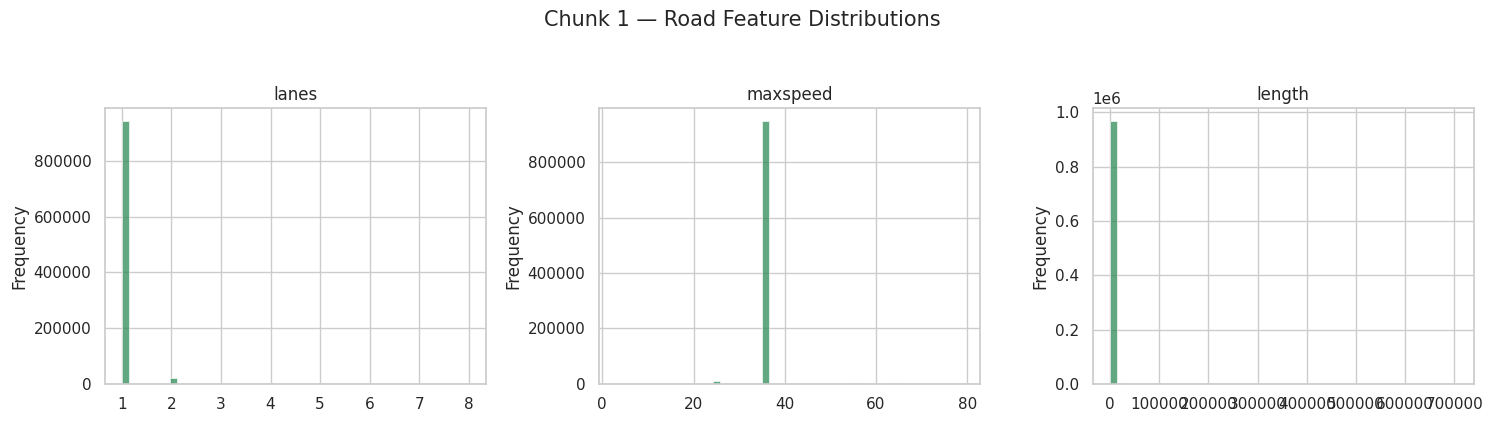

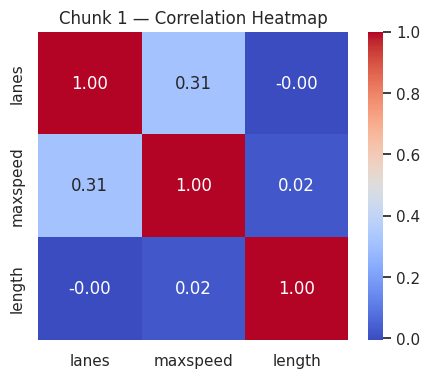

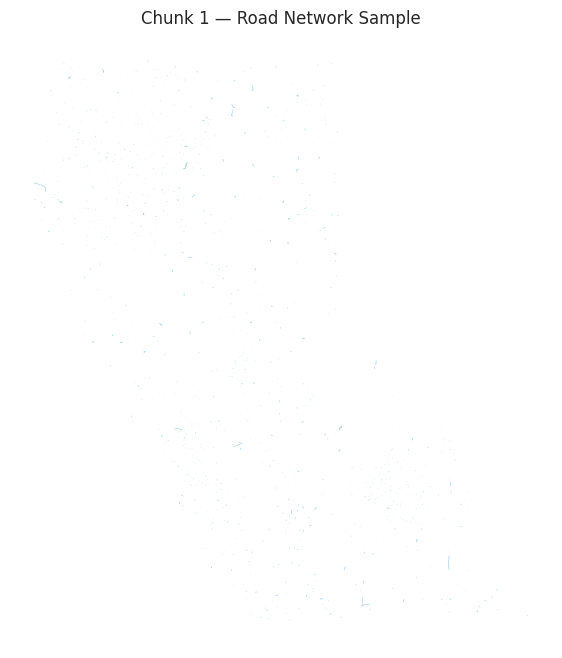

💾 Saved cleaned chunk 1 to: /content/drive/MyDrive/traffic_project/OSM_Roads_Chunk1.gpkg

🧹 Cleaning OSM chunk 2/3 ...


/tmp/ipython-input-1945707793.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['lanes'].fillna(1, inplace=True)
/tmp/ipython-input-1945707793.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

✅ Chunk 2 cleaned successfully: 969390 rows

📊 Quantitative Summary
               lanes       maxspeed         length
count  969390.000000  969390.000000  969390.000000
mean        1.133066      35.084982     358.024086
std         0.550662       3.816816    2115.015793
min         1.000000       3.000000       0.111319
25%         1.000000      35.000000      47.988114
50%         1.000000      35.000000     112.269829
75%         1.000000      35.000000     281.617157
max        30.000000     250.000000  776507.585224


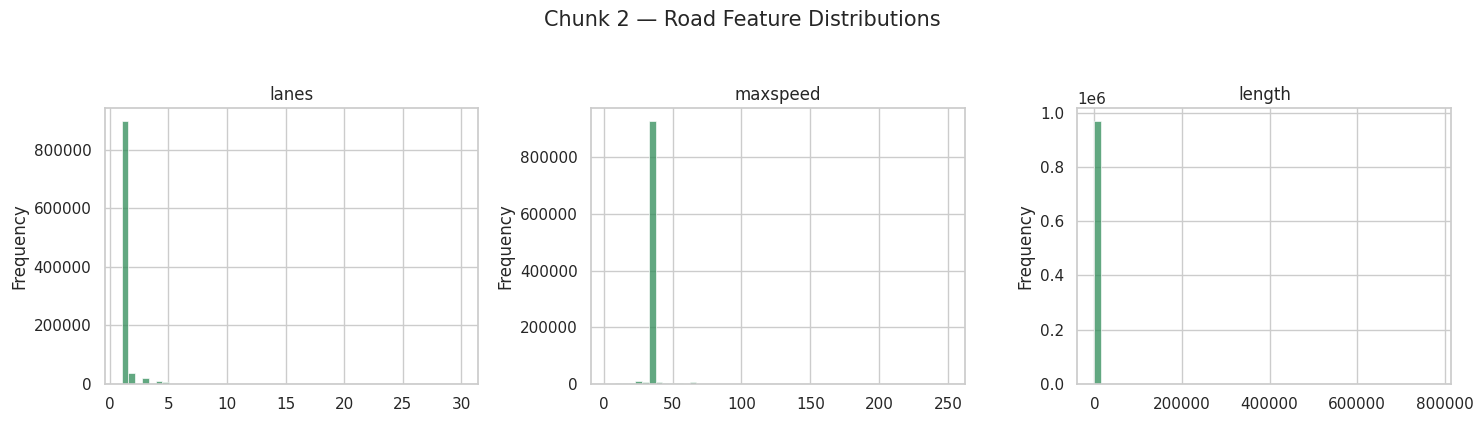

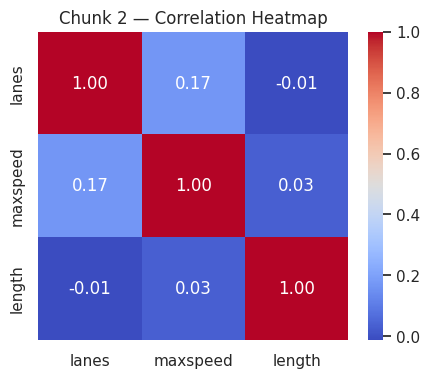

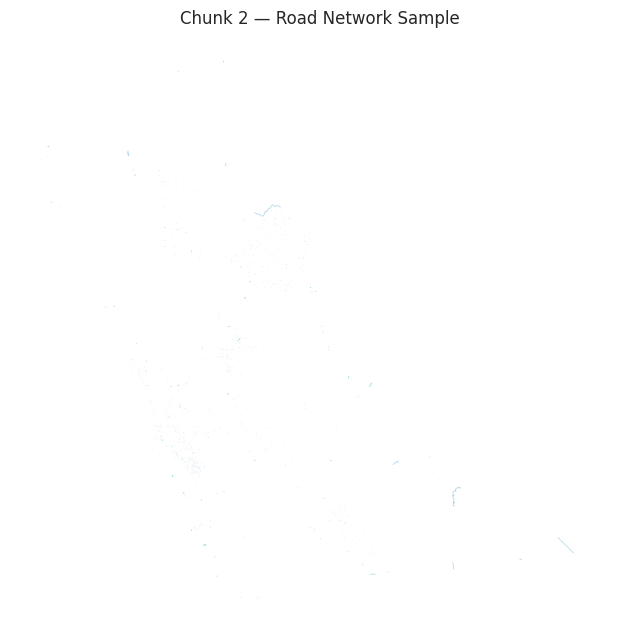

💾 Saved cleaned chunk 2 to: /content/drive/MyDrive/traffic_project/OSM_Roads_Chunk2.gpkg

🧹 Cleaning OSM chunk 3/3 ...


/tmp/ipython-input-1945707793.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['lanes'].fillna(1, inplace=True)
/tmp/ipython-input-1945707793.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

✅ Chunk 3 cleaned successfully: 969390 rows

📊 Quantitative Summary
               lanes       maxspeed         length
count  969390.000000  969390.000000  969390.000000
mean        1.082668      35.194553     279.661905
std         0.445395       4.762884    1269.096318
min         0.000000       1.000000       0.068261
25%         1.000000      35.000000      25.717524
50%         1.000000      35.000000      74.607890
75%         1.000000      35.000000     203.534025
max        13.000000     250.000000  414776.659586


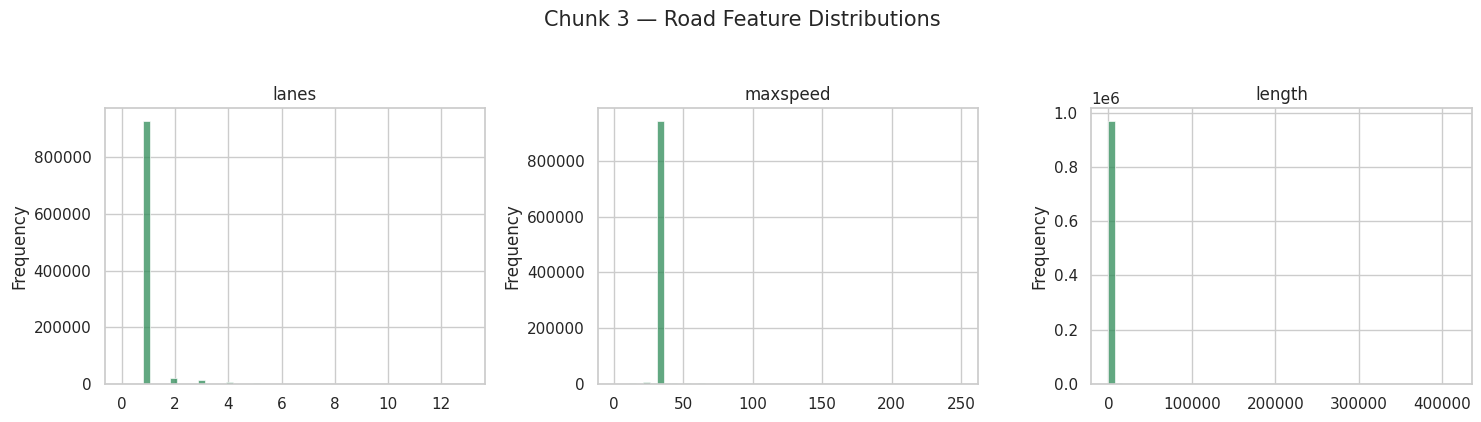

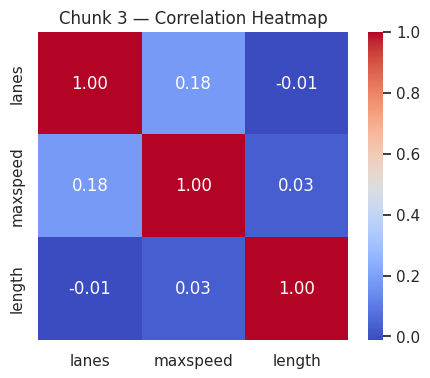

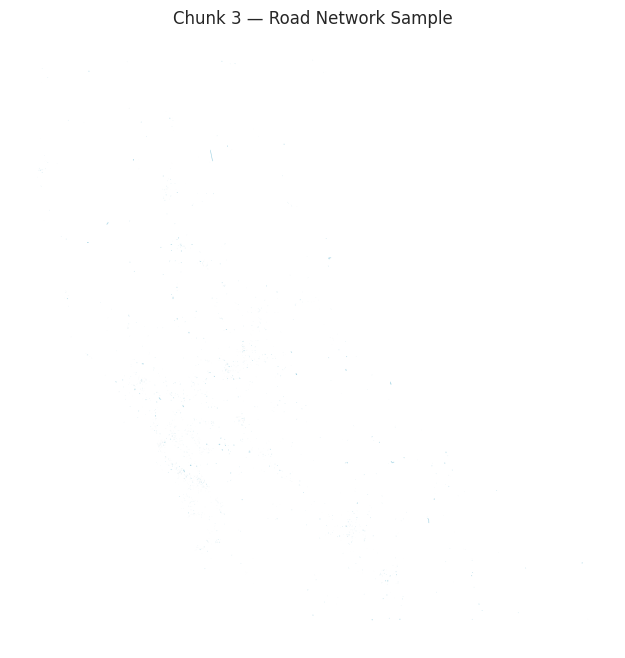

💾 Saved cleaned chunk 3 to: /content/drive/MyDrive/traffic_project/OSM_Roads_Chunk3.gpkg

🧹 Cleaning OSM chunk 4/3 ...
✅ Chunk 4 cleaned successfully: 2 rows

📊 Quantitative Summary
       lanes  maxspeed      length
count    2.0       2.0    2.000000
mean     1.0      35.0  410.173401
std      0.0       0.0  157.340605
min      1.0      35.0  298.916792
25%      1.0      35.0  354.545096
50%      1.0      35.0  410.173401
75%      1.0      35.0  465.801705
max      1.0      35.0  521.430009


/tmp/ipython-input-1945707793.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['lanes'].fillna(1, inplace=True)
/tmp/ipython-input-1945707793.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

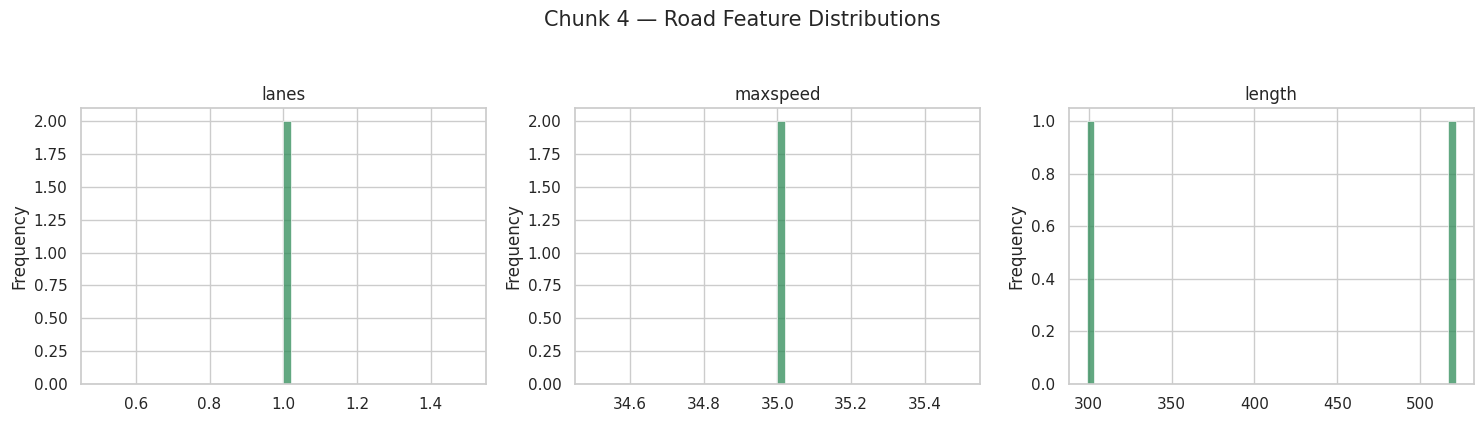

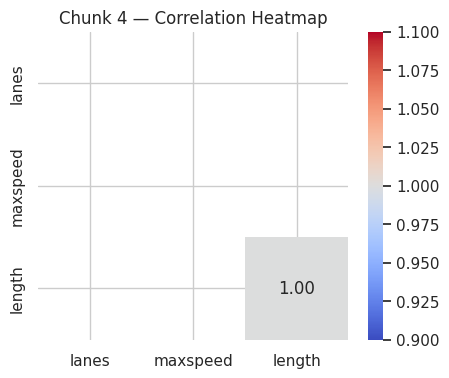

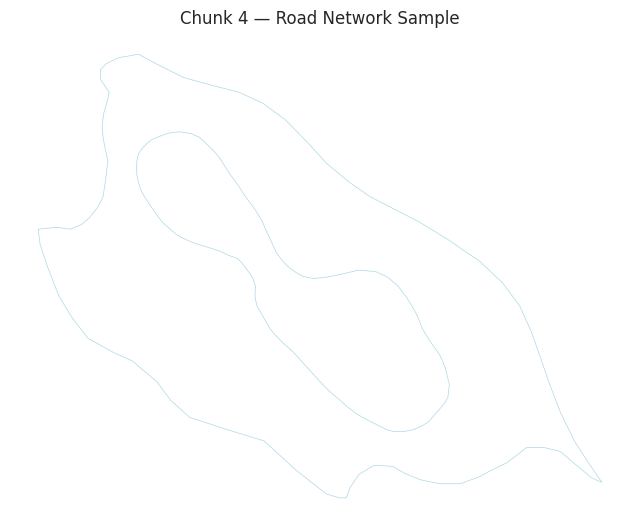

💾 Saved cleaned chunk 4 to: /content/drive/MyDrive/traffic_project/OSM_Roads_Chunk4.gpkg


In [ ]:
cleaned_chunks = []

for i, chunk in enumerate(chunks):
    cleaned = clean_osm_chunk(chunk, i)
    out_file = project_path + f'OSM_Roads_Chunk{i+1}.gpkg'
    cleaned.to_file(out_file, driver='GPKG')
    print(f"💾 Saved cleaned chunk {i+1} to: {out_file}")
    cleaned_chunks.append(cleaned)


In [ ]:
print("🔗 Merging all cleaned chunks...")
osm_combined = pd.concat(cleaned_chunks, ignore_index=True)
osm_combined.to_file(project_path + 'OSM_Roads_Cleaned_Combined.gpkg', driver='GPKG')
print("✅ Combined file saved successfully.")

🔗 Merging all cleaned chunks...
✅ Combined file saved successfully.
